### Project objective

The aim of this project is to implement a document (sentence) classification model with standard machine learning model and then slowly shift to modern approaches such as using transformer model.

### Dataset

To conduct the experiments, we use a subset of the `HumSet` dataset [1] (https://blog.thedeep.io/humset/). `HumSet` is created by the DEEP (https://www.thedeep.io) project – an open source platform which aims to facilitate processing of textual data for international humanitarian response organizations. The platform enables the classification of text excerpts, extracted from news and reports into a set of domain specific classes. The provided dataset contains the classes (labels) referring to the humanitarian sectors like agriculture, health, and protection. The dataset contains an overall number of 17,301 data points. 

We have the following files:

- `thedeep.subset.train.txt`: Train set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.validation.txt`: Validation set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.test.txt`: Test set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.labels.txt`: Captions of the labels.
- `thedeep.ToU.txt`: Terms of use of the dataset.


[1] HumSet: Dataset of Multilingual Information Extraction and Classification for Humanitarian Crises Response
*Selim Fekih, Nicolo' Tamagnone, Benjamin Minixhofer, Ranjan Shrestha, Ximena Contla, Ewan Oglethorpe and Navid Rekabsaz.* 
In Findings of the 2022 Conference on Empirical Methods in Natural Language Processing (Findings of EMNLP), December 2022.


<a name="section-preprocessing"></a><h2 style="color:rgb(0,120,170)">Pre-processing & Feature Extraction</h2>

In [39]:
import pandas as pd
import numpy as np
import nltk as nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import pickle
from sklearn.linear_model import LogisticRegression

In [2]:
def load_data(file_path):
    data=pd.read_csv(file_path,delimiter=",",header=None,names=['index','text','label'])
    return data

In [3]:
training_data=load_data("../data/thedeep.subset.train.txt")
validation_data=load_data('../data/thedeep.subset.validation.txt')
test_data=load_data('../data/thedeep.subset.test.txt')



<h3>Preprocessing steps:</h3>
Removed punctuation: Punctuation often does not contribute much information. Removing it reduces noise and simplifies the text.

Lowercasing: Helps reduce vocabulary size and avoids treating the same words as different entities.

Stop word removal: They carry little or no semantic information. Removing them reduces dimensionality and helps to focus on more important words.

Porter Stemmer: Using porter porter stemmer, we reduce the word to its root form that captures the essential meaning of different word variation and also helps the model to focus on key concepts and removing noise from inflected word forms and also reduces overfitting.We have used https://www.nltk.org/ for stemming.

Lemmatization: we have also tried to use lemmaitzation instead of stemming from wordnet but for some 
reason it didnot work with our code so we sticked to Porter Stemmer.

Tokenization: Important for splitting sentences into individual words. They then are the basis for further analysis. We used https://www.nltk.org/ for tokenization and stop word removal.



In [5]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khandoker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Khandoker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khandoker\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Khandoker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Khandoker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
stop_words=set(stopwords.words('english'))

stemmer=PorterStemmer()
lemmatizer = WordNetLemmatizer()


In [7]:
# Function to convert NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_pos_tag):
    if nltk_pos_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [8]:
def text_preprocessing(text,lemmatization=False):

    #removing punctuation and dates
    text=re.sub(r'[^\w\s]', '', text)
    text=re.sub(r'\d+','',text)

    # converting to lower case
    text=text.lower()

    tokens=word_tokenize(text)


    # removing stopwords:
    filtered_tokens=[token for token in tokens if token not in stop_words]

    # print(f"Filtered token: {filtered_tokens}")

    # doing stemming:
    if (not lemmatization):
        filtered_tokens=[stemmer.stem(token) for token in filtered_tokens]
        # print(f"stemming: {filtered_tokens}")
    else:
        words_with_pos=pos_tag(filtered_tokens)
        filtered_tokens=[lemmatizer.lemmatize(word,get_wordnet_pos(pos)) for word,pos in words_with_pos]
        # print(f'lemmatize: {filtered_tokens}')
    
    return filtered_tokens

In [9]:
training_data['tokens']=training_data['text'].apply(lambda x: text_preprocessing(x,lemmatization=False))
validation_data['tokens']=validation_data['text'].apply(lambda x:text_preprocessing(x,lemmatization=False))
test_data['tokens']=test_data['text'].apply(lambda x: text_preprocessing(x,lemmatization=False))

In [11]:
training_data.head(5)

,index,text,label,tokens
0,5446,In addition to the immediate life-saving inter...,9,"[addit, immedi, lifesav, intervent, unicef, ta..."
1,8812,There are approximately 2.6 million people cla...,3,"[approxim, million, peopl, classifi, phase, mi..."
2,16709,"While aid imports have held up recently, comme...",5,"[aid, import, held, recent, commerci, food, fu..."
3,3526,Heavy rainfalls as well as onrush of water fro...,0,"[heavi, rainfal, well, onrush, water, upstream..."
4,4928,"Based on field reports 9 , the main production...",3,"[base, field, report, main, product, challeng,..."


In [12]:
validation_data.head(5)

,index,text,label,tokens
0,633,The veterans threw up roadblocks on the main n...,9,"[veteran, threw, roadblock, main, northbound, ..."
1,6001,Water department complains about lack of skill...,11,"[water, depart, complain, lack, skill, worker,..."
2,14014,"On 13 February 2018, the Ministry of Health of...",4,"[februari, ministri, health, democrat, republ,..."
3,12225,"In Kakuma and Kalobeyei, both host and refugee...",7,"[kakuma, kalobeyei, host, refuge, commun, depe..."
4,10181,'Raqqa is now empty of civilians who had been ...,9,"[raqqa, empti, civilian, taken, human, shield,..."


In [13]:
test_data.head(5)

,index,text,label,tokens
0,5805,Overall 30% decrease in MAM Children admission...,8,"[overal, decreas, mam, children, admiss, april..."
1,17120,"In 2014, fear of Ebola also led to attacks on ...",9,"[fear, ebola, also, led, attack, health, worke..."
2,11901,"Wheat is the staple food for most Afghans, com...",3,"[wheat, stapl, food, afghan, compris, percent,..."
3,2589,We have received serious allegations that two ...,9,"[receiv, seriou, alleg, two, lna, fighter, sum..."
4,4188,"Somali: 67 of 93 woredas hotspot . 410k MAM, 4...",8,"[somali, woreda, hotspot, k, mam, k, sam, expect]"


### Creating Dictionaries

We reduced the dictionary by removing all words with less than 30 occurrences. We then apply OOV handling: we replace any word that is not in the dictionary anymore but appears in the text by the special token OOV.


In [14]:
#creating dictionaires:
from collections import Counter

all_tokens=[]

for tokens in training_data['tokens']:
    all_tokens.extend(tokens)

token_counts=Counter(all_tokens)
print('Intial Dictionary Size:',len(token_counts))

# reducing dictionaries:
frequency_threshold=30
reduced_dictionary={}

for word,count in token_counts.items():
    if count>=frequency_threshold:
        reduced_dictionary[word]=count

print(type(reduced_dictionary))
print("Reduced Dictionary size:",len(reduced_dictionary))

# handling oov:

def handle_oov(tokens,dictionary,oov_token='<OOV>'):
    return [word if word in dictionary else oov_token for word in tokens]


#applying handle oov to the three datasets:

training_data['tokens_oov']=training_data['tokens'].apply(lambda tokens:handle_oov(tokens,reduced_dictionary))
validation_data['tokens_oov']=validation_data['tokens'].apply(lambda tokens:handle_oov(tokens,reduced_dictionary))
test_data['tokens_oov']=test_data['tokens'].apply(lambda tokens:handle_oov(tokens,reduced_dictionary))

training_data.head(5)

Intial Dictionary Size: 23405
<class 'dict'>
Reduced Dictionary size: 2099


,index,text,label,tokens,tokens_oov
0,5446,In addition to the immediate life-saving inter...,9,"[addit, immedi, lifesav, intervent, unicef, ta...","[addit, immedi, lifesav, intervent, unicef, ta..."
1,8812,There are approximately 2.6 million people cla...,3,"[approxim, million, peopl, classifi, phase, mi...","[approxim, million, peopl, classifi, phase, mi..."
2,16709,"While aid imports have held up recently, comme...",5,"[aid, import, held, recent, commerci, food, fu...","[aid, import, held, recent, commerci, food, fu..."
3,3526,Heavy rainfalls as well as onrush of water fro...,0,"[heavi, rainfal, well, onrush, water, upstream...","[heavi, rainfal, well, <OOV>, water, <OOV>, <O..."
4,4928,"Based on field reports 9 , the main production...",3,"[base, field, report, main, product, challeng,...","[base, field, report, main, product, challeng,..."


### Creating Sentence Vectors:

We used tf-idf (using tf version 1 as presented in the lecture slides) and tc to create the document representation vectors.

In [15]:
def calculate_tc_vectors(doc):
    word_counts=Counter(doc)
    tc_vector=[word_counts[word] if word in word_counts else 0 for word in reduced_dictionary]
    return tc_vector

train_tc_vectors = [calculate_tc_vectors(doc) for doc in training_data['tokens_oov']]
validation_tc_vectors = [calculate_tc_vectors(doc) for doc in validation_data['tokens_oov']]
test_tc_vectors = [calculate_tc_vectors(doc) for doc in test_data['tokens_oov']]

In [16]:
num_docs=len(training_data)  
idf={}

for word in reduced_dictionary:
    doc_count=sum(1  for doc in training_data['tokens_oov'] if word in doc)
    idf[word]=np.log(num_docs/(1+doc_count))

In [18]:
# idf

In [19]:
def calc_tf_vector(doc):
    tc_vector = calculate_tc_vectors(doc) 
    doc_length = len(doc)
    return [term_count / doc_length if doc_length > 0 else 0 for term_count in tc_vector]


def calculate_tfidf_vector(doc):
    tf_vector = calc_tf_vector(doc)
    tfidf_vector = [tf * idf[word] for tf, word in zip(tf_vector, reduced_dictionary)]
    return tfidf_vector

train_tfidf_v1_vectors = [calculate_tfidf_vector(doc) for doc in training_data['tokens_oov']]
validation_tfidf_v1_vectors = [calculate_tfidf_vector(doc) for doc in validation_data['tokens_oov']]
test_tfidf_v1_vectors = [calculate_tfidf_vector(doc) for doc in test_data['tokens_oov']]


print("TF-IDF:")
for vec in train_tfidf_v1_vectors[:3]:  
    print(vec[:10])  

TF-IDF:
[np.float64(0.20653774971599914), np.float64(0.29491337699881365), np.float64(0.3509393190582141), np.float64(0.2982885830595669), np.float64(0.27860918757160075), np.float64(0.27575166367062226), np.float64(0.30859874796876247), np.float64(0.21644107066537724), np.float64(0.13564633041373478), np.float64(0.2347067650760074)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.06424677173590673), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [20]:
# sparsity 
#sparsity is same for tc or tf-idf, therefore we only need to calculate it once
# since if there is a 0 in tc vector, there will be 0 in tf idf vector
def calculate_sparsity(vectors):
    total_count = len(vectors) * len(vectors[0])  
    zero_count = sum(vector.count(0) for vector in vectors)
    sparsity_rate = (zero_count / total_count) * 100
    return sparsity_rate

In [21]:
train_tc_sparsity = calculate_sparsity(train_tc_vectors)
validation_tc_sparsity = calculate_sparsity(validation_tc_vectors)
test_tc_sparsity = calculate_sparsity(test_tc_vectors)
print(f"Train TC Sparsity: {train_tc_sparsity}%")
print(f"Validation TC Sparsity: {validation_tc_sparsity}%")
print(f"Test TC Sparsity: {test_tc_sparsity}%")

Train TC Sparsity: 98.67220008426804%
Validation TC Sparsity: 98.68954032700287%
Test TC Sparsity: 98.69232160281848%


<a name="section-training"></a><h2 style="color:rgb(0,120,170)"> Training and Results Analysis</h2>

<h3>Machine Learning Model Evaluation and Analysis</h3>

**1 .Defining the Baseline Model**  
The first step involves establishing a simple baseline model that does not utilize any feature vectors. Instead, it will predict labels based on the label distribution in the training data. This dummy classifier serves as a reference point, ensuring that the actual machine learning models provide meaningful improvements over a naive approach.

**2. Training and Hyperparameter Tuning for Classification Models** 
Two classification algorithms will be selected from standard machine learning methods, and models will be trained using two variations of feature vectors. This will result in four experimental setups (2 classifiers × 2 feature variations).

For each classifier, one hyperparameter will be chosen for tuning. The tuning process involves:  
- Assigning at least three different values to the selected hyperparameter.  
- Training separate models using each hyperparameter value.  
- Evaluating their performance on the validation set.  
- Selecting the best-performing hyperparameter value based on the validation results.  

The tuning results will be documented, including the tested hyperparameter values, their corresponding evaluation scores on the validation set, and the final choice.

**3. Evaluation and Comparison of Results** 
The four selected models (one per experimental setup) will be evaluated on both the validation and test sets. Their performance metrics will be reported in:  
- A **table** displaying validation and test results side by side for easy comparison.  
- A **visualization (plot)** summarizing the results for better interpretability.  

The comparison will analyze patterns in the results. If there are differences between validation and test performance (such as lower test scores), potential causes will be discussed. Factors contributing to improved classification accuracy will also be identified.

**4. Confusion Matrix Analysis**  
The best-performing model will be selected, and a **confusion matrix** will be generated. This matrix will provide insights into classification errors by showing the relationship between predicted and actual labels. The focus will be on identifying major misclassifications and understanding which classes tend to be confused with others.

**5. Feature Visualization Using TSNE** 
To further analyze the model’s behavior, the feature representations of the test set will be projected into a 2D space using the **TSNE method**. Two scatter plots will be created:  
- One where data points are colored according to their **true labels**.  
- One where data points are colored based on their **predicted labels**. 

Creating baseline:

In [22]:
counts_per_label = training_data['label'].value_counts()
total_count = counts_per_label.sum()
label_distribution = {label: count / total_count for label, count in counts_per_label.items()}

In [23]:
#predict labels based on training distribution
def predict_label(num_of_preds, distribution):
    labels  = list(distribution.keys())
    probs = list(distribution.values())
    return np.random.choice(labels, size=num_of_preds, p=probs)

In [24]:
#predictions for validation and test sets
val_labels = validation_data['label']
test_labels = test_data['label']

In [25]:
from sklearn.metrics import accuracy_score
val_preds = predict_label(len(val_labels), label_distribution)
test_preds = predict_label(len(test_labels), label_distribution)

val_accuracy = accuracy_score(val_labels, val_preds)
test_accuracy = accuracy_score(test_labels, test_preds)


print(f"Validation accuracy for baseline model: {val_accuracy}")
print(f"Test accuracy for baseline model: {test_accuracy}")

Validation accuracy for baseline model: 0.14445300462249616
Test accuracy for baseline model: 0.15645472061657031


Training and tuning classifier: We have experimented with different classifiers(Random Forest,Support Vector Machine, XGBoost)

Random Forest: It is an ensemble learning model with multiple decision trees.We have tune max_features as hyper parameters and tried to find the best hyper parameter settings.

SVM: Support Vector Machines are effective for high-dimensional spaces and can work well with sparse data, which is typical in text classification. They are particularly useful for binary and multiclass text classification tasks.

XGBoost: It is gradient boosting algorithm that builds an ensemble of decision trees.We have tuned and tried different learning rates to see how this model performs on our data.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# tc:
best_models = {}
validation_results = {}

max_features_values=['sqrt','log2',None]
feature_values_learning_rate = [0.001, 0.01, 0.1]  
print('Training Random Forest on TC :')
for feature in max_features_values:
    model=RandomForestClassifier(max_features=feature,random_state=42)
    model.fit(train_tc_vectors,training_data['label'])
    val_predictions=model.predict(validation_tc_vectors)
    accuracy=accuracy_score(validation_data['label'],val_predictions)
    print(f"Random forest max-feature {feature} on TC -Validation Accuracy:{accuracy:.4f}")

    if "RandomForest(TC)" not in best_models or accuracy > validation_results.get("RandomForest(TC)", (0, 0))[1]:
        best_models['RandomForest(TC)']=model
        validation_results['RandomForest(TC)']=(feature,accuracy)

# tf-idf vectors:
print('Training Random Forest on tf-idf:')
for feature in max_features_values:
    model=RandomForestClassifier(max_features=feature,random_state=42)
    model.fit(train_tfidf_v1_vectors,training_data['label'])
    val_predictions=model.predict(validation_tfidf_v1_vectors)
    accuracy=accuracy_score(validation_data['label'],val_predictions)
    print(f"Random forest max-feature {feature} on TC -Validation Accuracy:{accuracy:.4f}")

    if "RandomForest(Tf-idf)" not in best_models or accuracy > validation_results.get("RandomForest(Tf-idf)", (0, 0))[1]:
        best_models['RandomForest(Tf-idf)']=model
        validation_results['RandomForest(Tf-idf)']=(feature,accuracy)




print('Training Xgboots on tc:')
for feature in feature_values_learning_rate:
    model = XGBClassifier(learning_rate=feature, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(train_tc_vectors,training_data['label'])
    val_predictions=model.predict(validation_tc_vectors)
    accuracy=accuracy_score(validation_data['label'],val_predictions)
    print(f"XGB with learning rate {feature} on TC -Validation Accuracy:{accuracy:.4f}")

    if "XGB(TC)" not in best_models or accuracy > validation_results.get("XGB(TC)", (0, 0))[1]:
        best_models['XGB(TC)']=model
        validation_results['XGB(TC)']=(feature,accuracy)




print('Training Xgboots on tfidf:')
for feature in feature_values_learning_rate:
    model = XGBClassifier(learning_rate=feature, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(train_tfidf_v1_vectors,training_data['label'])
    val_predictions=model.predict(validation_tfidf_v1_vectors)
    accuracy=accuracy_score(validation_data['label'],val_predictions)
    print(f"XGB with learning rate {feature} on tfid -Validation Accuracy:{accuracy:.4f}")

    if "XGB(Tf-idf)" not in best_models or accuracy > validation_results.get("XGB(Tf-idf)", (0, 0))[1]:
        best_models['XGB(Tf-idf)']=model
        validation_results['XGB(Tf-idf)']=(feature,accuracy)

Training Random Forest on TC :
Random forest max-feature sqrt on TC -Validation Accuracy:0.7881
Random forest max-feature log2 on TC -Validation Accuracy:0.7735
Random forest max-feature None on TC -Validation Accuracy:0.7573
Training Random Forest on tf-idf:
Random forest max-feature sqrt on TC -Validation Accuracy:0.7839
Random forest max-feature log2 on TC -Validation Accuracy:0.7700
Random forest max-feature None on TC -Validation Accuracy:0.7650
Training Xgboots on tc:


f:\jku uni\5th semester\nlp\project\document-classification\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB with learning rate 0.001 on TC -Validation Accuracy:0.7354


f:\jku uni\5th semester\nlp\project\document-classification\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB with learning rate 0.01 on TC -Validation Accuracy:0.7523


f:\jku uni\5th semester\nlp\project\document-classification\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:45:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB with learning rate 0.1 on TC -Validation Accuracy:0.7908
Training Xgboots on tfidf:


f:\jku uni\5th semester\nlp\project\document-classification\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB with learning rate 0.001 on tfid -Validation Accuracy:0.7315


f:\jku uni\5th semester\nlp\project\document-classification\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB with learning rate 0.01 on tfid -Validation Accuracy:0.7508


f:\jku uni\5th semester\nlp\project\document-classification\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:48:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB with learning rate 0.1 on tfid -Validation Accuracy:0.7908


In [28]:
from sklearn.svm import LinearSVC
svm_c_values = [0.01, 0.1, 1.0, 5.0, 10.0]
print("\nTraining SVM on TF-IDF vectors...")
for c in svm_c_values:
    model = LinearSVC(C=c, max_iter=1000, random_state=42)
    model.fit(train_tfidf_v1_vectors, training_data['label'])
    val_predictions = model.predict(validation_tfidf_v1_vectors)
    accuracy = accuracy_score(validation_data['label'], val_predictions)
    print(f"SVM (C={c}) on TF-IDF - Validation Accuracy: {accuracy:.4f}")
    
   
    if "SVM (TF-IDF)" not in best_models or accuracy > validation_results.get("SVM (TF-IDF)", (0, 0))[1]:
        best_models["SVM (TF-IDF)"] = model
        validation_results["SVM (TF-IDF)"] = (c, accuracy)


Training SVM on TF-IDF vectors...
SVM (C=0.01) on TF-IDF - Validation Accuracy: 0.7219
SVM (C=0.1) on TF-IDF - Validation Accuracy: 0.8028
SVM (C=1.0) on TF-IDF - Validation Accuracy: 0.8051
SVM (C=5.0) on TF-IDF - Validation Accuracy: 0.7758
SVM (C=10.0) on TF-IDF - Validation Accuracy: 0.7612


In [29]:
print("\nTraining SVM on Term Count (TC) vectors...")
for c in svm_c_values:
    model = LinearSVC(C=c, max_iter=1000, random_state=42)
    model.fit(train_tc_vectors, training_data['label'])
    val_predictions = model.predict(validation_tc_vectors)
    accuracy = accuracy_score(validation_data['label'], val_predictions)
    print(f"SVM (C={c}) on TC - Validation Accuracy: {accuracy:.4f}")
    if "SVM (TC)" not in best_models or accuracy > validation_results.get("SVM (TC)", (0, 0))[1]:
        best_models["SVM (TC)"] = model
        validation_results["SVM (TC)"] = (c, accuracy)


Training SVM on Term Count (TC) vectors...
SVM (C=0.01) on TC - Validation Accuracy: 0.8070
SVM (C=0.1) on TC - Validation Accuracy: 0.7812
SVM (C=1.0) on TC - Validation Accuracy: 0.7331


C:\Users\Khandoker\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM (C=5.0) on TC - Validation Accuracy: 0.7149


C:\Users\Khandoker\AppData\Roaming\Python\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM (C=10.0) on TC - Validation Accuracy: 0.7088


In [30]:
print("\nBest Model Results:")
for model_type, (best_param, best_accuracy) in validation_results.items():
    print(f"{model_type} - Best Parameter: {best_param}, Validation Accuracy: {best_accuracy:.4f}")


Best Model Results:
RandomForest(TC) - Best Parameter: sqrt, Validation Accuracy: 0.7881
RandomForest(Tf-idf) - Best Parameter: sqrt, Validation Accuracy: 0.7839
XGB(TC) - Best Parameter: 0.1, Validation Accuracy: 0.7908
XGB(Tf-idf) - Best Parameter: 0.1, Validation Accuracy: 0.7908
SVM (TF-IDF) - Best Parameter: 1.0, Validation Accuracy: 0.8051
SVM (TC) - Best Parameter: 0.01, Validation Accuracy: 0.8070


In [32]:
file_name="best_models.pkl"

with open(file_name,'wb') as file:
    pickle.dump(best_models,file)

print("Best models have been saved")

Best models have been saved


In [33]:
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

#Evaluting on test sets:

test_results={}

for model_name,model in best_models.items():
    if "TF-IDF" in model_name:
        test_predictions=model.predict(test_tfidf_v1_vectors)

    else:
        test_predictions=model.predict(test_tc_vectors)

    
    accuracy=accuracy_score(test_data['label'],test_predictions)
    test_results[model_name]=accuracy

results_df=pd.DataFrame({
    'Model': list(validation_results.keys()),
    'Best Validation Parameter': [param[0] for param in validation_results.values()],
    'Validation Accuracy': [acc[1] for acc in validation_results.values()],
    'Test Accuracy': [test_results[model_name] for model_name in validation_results.keys()]
})

results_df.to_csv('results_df.csv',index=False)

results_df

,Model,Best Validation Parameter,Validation Accuracy,Test Accuracy
0,RandomForest(TC),sqrt,0.788136,0.789981
1,RandomForest(Tf-idf),sqrt,0.783898,0.783815
2,XGB(TC),0.1,0.790832,0.796532
3,XGB(Tf-idf),0.1,0.790832,0.770713
4,SVM (TF-IDF),1.0,0.805085,0.805395
5,SVM (TC),0.01,0.807011,0.797688


RandomForest(TC): The test accuracy is slightly higher than the validation accuracy and this indicates that model is generalizing well and do not overfit on validation data. I think it is because of the removal of noises created by unncessary and repetitive words. Since we have done stemming, removal of stop words and punctuation marks, the model is performing better with term counts and also the robustness of the model also helps to improve a bit here.

RandomForest(Tf-idf): Even here the model seems to perform well on test data , resulting in better generalization and the reason is same as previous randomForest(tc)

XGB(TC and Tf-idf): The model is performing well with TC vectors since test accuracy is higher than validation but for Tf-idf it seems to overfit and it is probably because the model is not properly tuned as a result the model is memorizing a pattern from validation data.

SVM(TF-IDF and TC): Both svm performs well and generalize well and reason for this is ofcourse the preprocessing steps we took and besides the preprocessing steps, the model itself is pretty good for classification and for high dimensional data SVM performs better with classification.

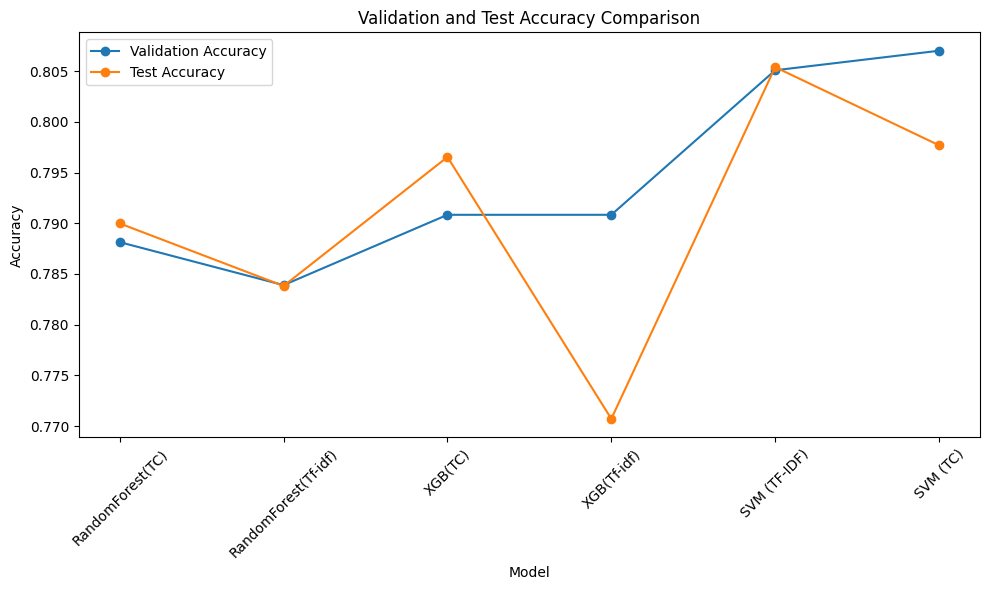

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
index = range(len(results_df))


ax.plot(index, results_df['Validation Accuracy'], marker='o', linestyle='-', label='Validation Accuracy')
ax.plot(index, results_df['Test Accuracy'], marker='o', linestyle='-', label='Test Accuracy')


ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Validation and Test Accuracy Comparison')
ax.set_xticks(index)
ax.set_xticklabels(results_df['Model'], rotation=45)
ax.legend()

plt.tight_layout()
plt.savefig("accuracy_comparison_of_traditional_methods.png",dpi=300,bbox_inches='tight')

plt.show()

From the graph, all the models are performing relatively well. SVM(TF-IDF) performs the best among others and XGB(Tf-idf) is slightly overfitting.

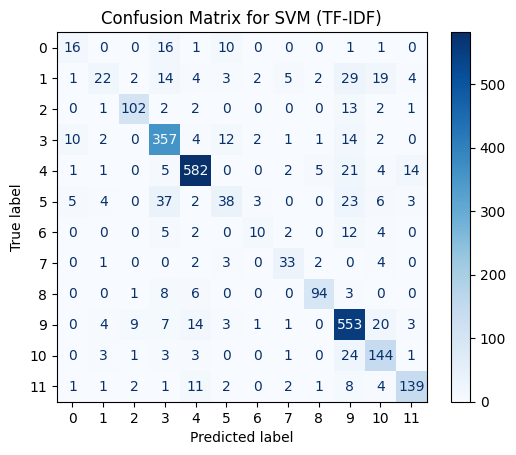

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


test_predictions = best_models['SVM (TF-IDF)'].predict(test_tfidf_v1_vectors)
cm = confusion_matrix(test_data['label'], test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix for SVM (TF-IDF)')
plt.savefig("confusion_matrix_traditional_approach.png",dpi=300,bbox_inches='tight')
plt.show()

From the matrix , we can see that most of the values are concentrated along the diagonal , indicating that the model correctly classified a large portion of the instances in each class. For example, high counts on diagonal for label 3 (357) ,4 (582), 9 (553) and these suggest a good clarification of the classes.

Class 5 and class 3: We can see that between this two class there is misclassification of 37 instances

class 5 and class 9: misclassification of 23 instances

class 1 and 9 : misclassification of 29 instances

class 0 and 3: missclassification of 10 instances

We can also observe that there are some classes which is appearing more for example class 4 and class 9 whereas there are some classes which is appearing less for example class 1 and class 0 and this suggest that the dateset might be imbalanced.

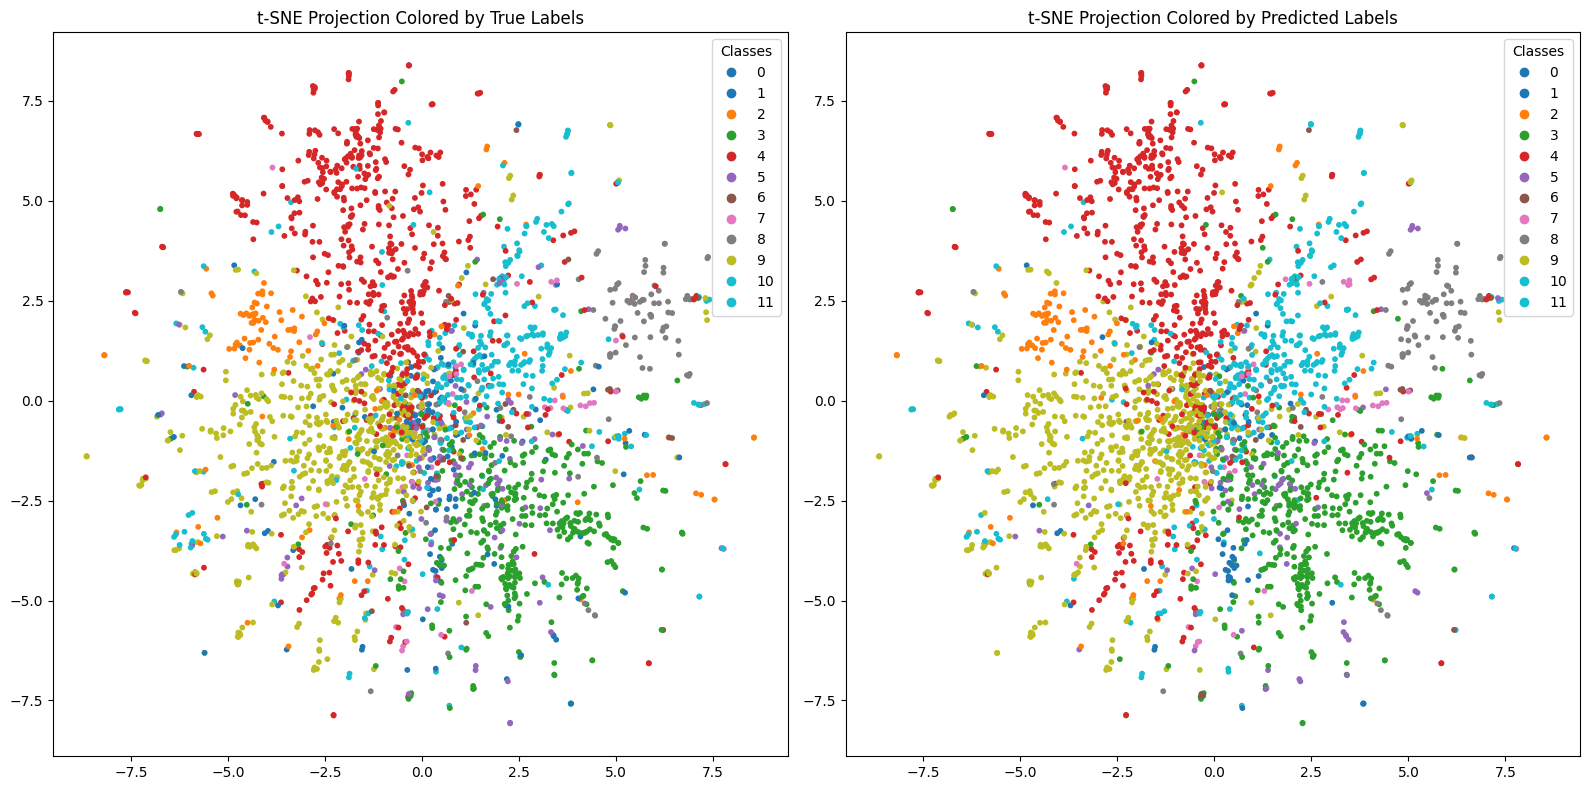

In [38]:
# Feature Visualization:
from sklearn.manifold import TSNE
test_tfidf_v1_vectors_numpy = np.array(test_tfidf_v1_vectors)


tsne = TSNE(n_components=2, random_state=42)
test_vectors_2d = tsne.fit_transform(test_tfidf_v1_vectors_numpy)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


scatter1 = ax1.scatter(test_vectors_2d[:, 0], test_vectors_2d[:, 1], c=test_data['label'], cmap='tab10', s=10)
ax1.set_title('t-SNE Projection Colored by True Labels')
ax1.legend(*scatter1.legend_elements(), title="Classes", loc="upper right")

scatter2 = ax2.scatter(test_vectors_2d[:, 0], test_vectors_2d[:, 1], c=test_predictions, cmap='tab10', s=10)
ax2.set_title('t-SNE Projection Colored by Predicted Labels')
ax2.legend(*scatter2.legend_elements(), title="Classes", loc="upper right")

plt.tight_layout()
plt.savefig("tsne_traditional_approach.png",dpi=300,bbox_inches='tight')
plt.show()

Both the clusters is similiar apart from slight difference due to slight misclassification and the cluster suggest that the model is generalizing pretty well.

<a name="section-optional"></a><h2 style="color:rgb(0,120,170)"> Linear Model Interpretability</h2>

***Feature: Token Importance Analysis using Logistic Regression***

Implement a logistic regression model on a chosen document representation. Extract the learned coefficient weights for each token in the dictionary. For each class, identify the most influential tokens contributing to model predictions. This feature helps interpret model decisions and enhances explainability.


In [40]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
log_reg.fit(train_tfidf_v1_vectors, training_data['label'])

C:\Users\Khandoker\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [42]:

feature_names = list(reduced_dictionary)
coef = log_reg.coef_

n = 10 # considering top 10 tokens
top_tokens_dict = {}

for index in range(coef.shape[0]):
    coefs = coef[index]
    
    top_idx = np.argsort(coefs)[-n:]
    top_tokens = [(feature_names[i], coefs[i]) for i in reversed(top_idx)]
    top_tokens_dict[index] = {
        "Top_Tokens": top_tokens}


for index, tokens in top_tokens_dict.items():
    print(f"Class {index}:")
    print("Contributing Tokens:", tokens["Top_Tokens"])
    

Class 0:
Contributing Tokens: [('crop', np.float64(4.121641179785865)), ('agricultur', np.float64(3.7477175308214763)), ('product', np.float64(3.3312777050427824)), ('farmer', np.float64(3.2712435045921273)), ('hectar', np.float64(3.1324134625812174)), ('harvest', np.float64(2.707876464342913)), ('armyworm', np.float64(2.4622791302974067)), ('fall', np.float64(2.3148773714756214)), ('rainfal', np.float64(2.3116792199296112)), ('infest', np.float64(2.0724238307738916))]
Class 1:
Contributing Tokens: [('humanitarian', np.float64(2.9463377419044803)), ('assist', np.float64(2.565020902911542)), ('flood', np.float64(2.3993533585141598)), ('itali', np.float64(2.0392875704400355)), ('displac', np.float64(1.889838979348454)), ('return', np.float64(1.8725164311446758)), ('refuge', np.float64(1.7882098526885384)), ('item', np.float64(1.7089316185744479)), ('disast', np.float64(1.6609925514723078)), ('aid', np.float64(1.6121669150905031))]
Class 2:
Contributing Tokens: [('school', np.float64(12.5